In [27]:
import re
import string
import numpy as np
import random
import pandas as pd

#For data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline
import plotly.graph_objects as go
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#For NLP
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

In [28]:
def random_colours(number_of_colors):
  colors=[]
  for i in range(number_of_colors):
    colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
  return colors

In [29]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
ss=pd.read_csv('sample_submission.csv')

In [30]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [32]:
#dropping row with null value
train.dropna(inplace=True)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [35]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [36]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [37]:
temp=train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [38]:
#Funnel Chart for sentiments
fig=go.Figure(go.Funnelarea(
    text=temp.sentiment,
    values=temp.text,
    title={"position":"top center","text":"Funnel=Chart of Sentiment Distribution"}
))
fig.show()

In [39]:
def jaccard(str1,str2):
  a=set(str1.lower().split())
  b=set(str2.lower().split())
  c=a.intersection(b)
  return(float(len(c))/(len(a) + len(b) - len(c)))

In [40]:
results_jaccard=[]
for ind,row in train.iterrows():
  sentence1=row.text
  sentence2=row.selected_text
  jaccard_score=jaccard(sentence1, sentence2)
  results_jaccard.append([sentence1,sentence2,jaccard_score])

In [41]:
jaccard=pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train=train.merge(jaccard,how='outer')

In [42]:
train['Num_words_ST']=train['selected_text'].apply(lambda x:len(str(x).split()))
train['Num_words_text']=train['text'].apply(lambda x:len(str(x).split()))
train['difference_in_words']=train['Num_words_text']-train['Num_words_ST']

In [43]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [44]:
print(((train['Num_words_ST']==2) & (train['sentiment']=='neutral')).sum())
print((train['Num_words_text']).count())

291
27480


In [45]:
hist_data = [train['Num_words_ST'],train['Num_words_text']]
print(hist_data)

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

[0         7
1         2
2         2
3         3
4         3
         ..
27475     2
27476     3
27477     6
27478     6
27479    11
Name: Num_words_ST, Length: 27480, dtype: int64, 0         7
1        10
2         5
3         5
4        14
         ..
27475    16
27476    23
27477    22
27478     6
27479    11
Name: Num_words_text, Length: 27480, dtype: int64]


<ipython-input-46-ed2bb69bd4c7>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-46-ed2bb69bd4c7>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




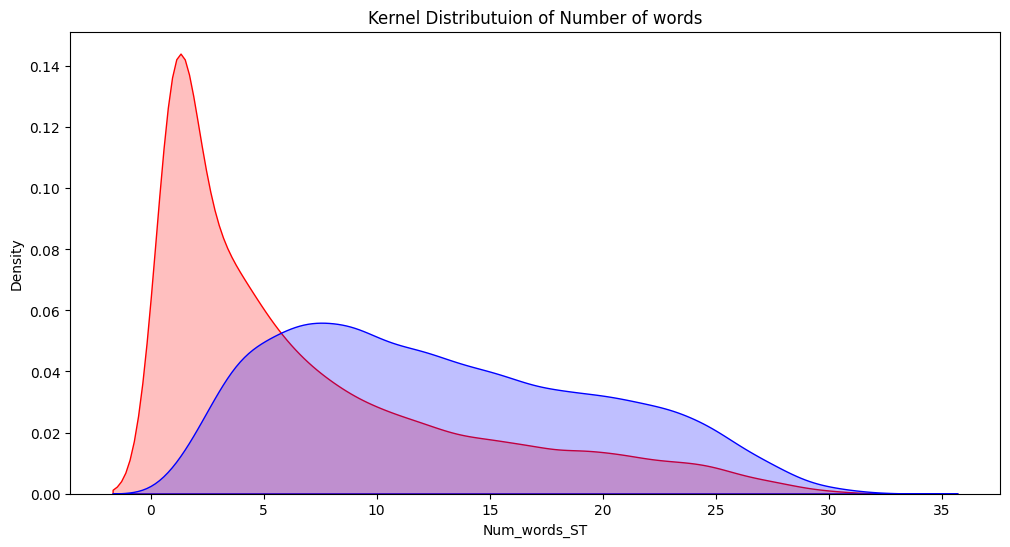

In [46]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distributuion of Number of words')
p1=sns.kdeplot(train['Num_words_text'], shade=True, color="b")

In [47]:
print((train[train['sentiment']=='neutral']['difference_in_words']==2).sum())
print((train[train['sentiment']=='negative']['difference_in_words']==1).sum())
print((train[train['sentiment']=='neutralv']['Num_words_text']).count())
print((train[train['sentiment']=='negative']['difference_in_words']).count())

134
192
0
7781


<ipython-input-48-06e91bddaacf>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-48-06e91bddaacf>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




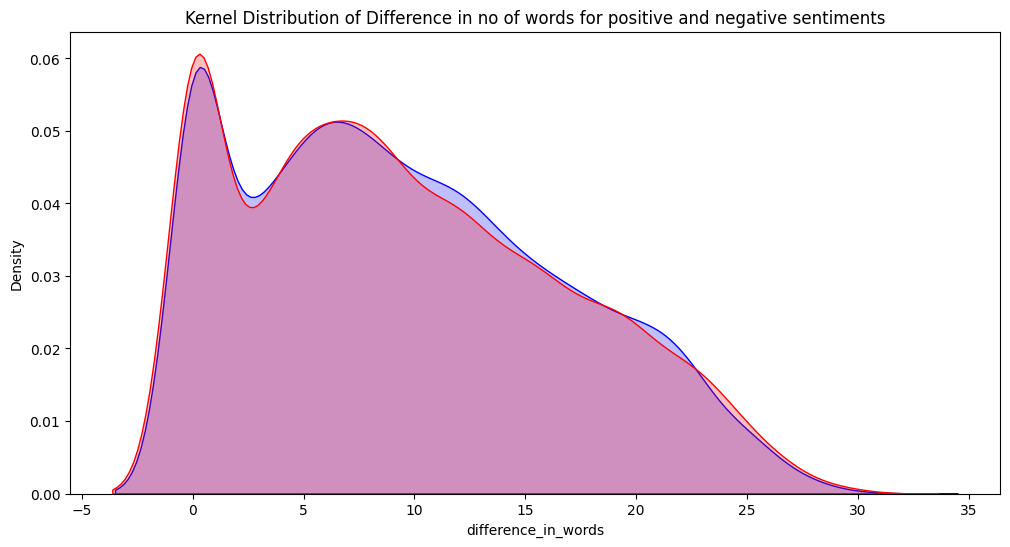

In [48]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in no of words for positive and negative sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

<ipython-input-49-b5a00873ebef>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Kernel Distribution of Difference in no of words for neutral sentiments')

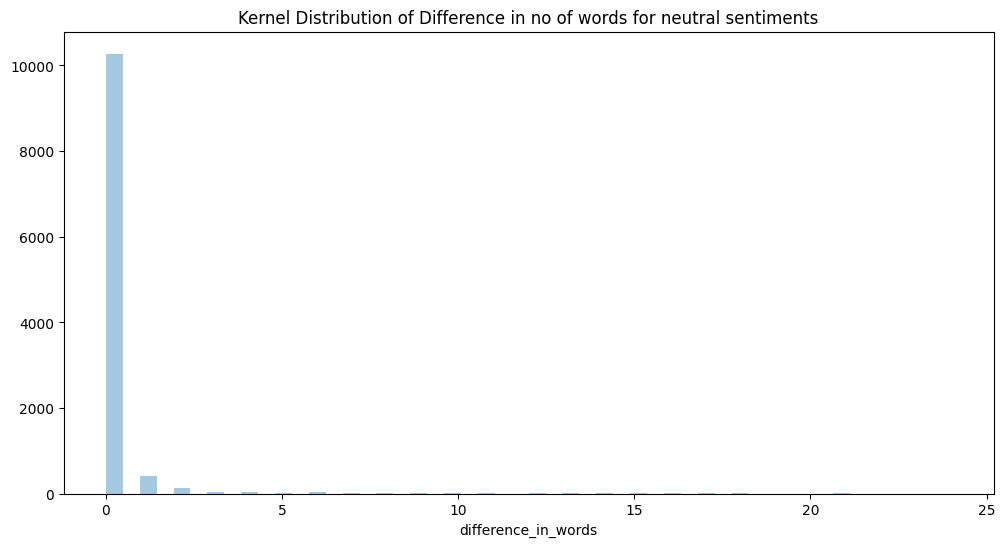

In [49]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False).set_title('Kernel Distribution of Difference in no of words for neutral sentiments')

<ipython-input-50-65f38ec350bd>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-50-65f38ec350bd>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




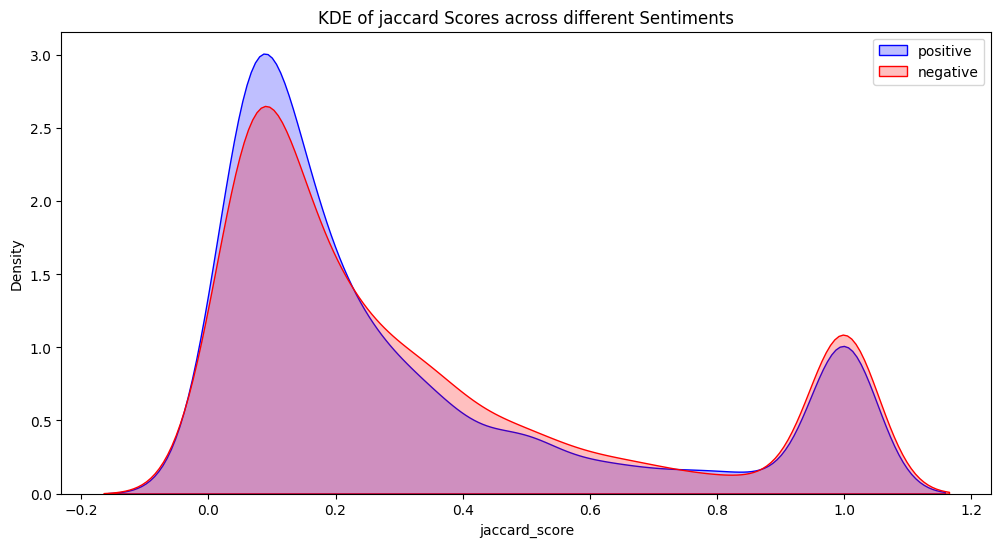

In [50]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'],shade=True, color="r")
plt.legend(labels=['positive','negative'])

<ipython-input-51-bf0af01b29f1>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='jaccard_score'>

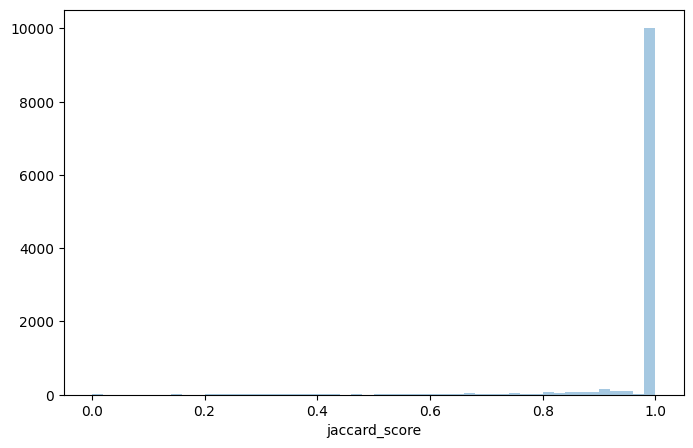

In [51]:
plt.figure(figsize=(8,5))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

In [52]:
#k=train[train['Num_words_text']<=2]
#k.groupby('sentiment').mean()['jaccard_score']

In [53]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


In [54]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [55]:
train['text']=train['text'].apply(lambda x:clean_text(x))
train['selected_text']=train['selected_text'].apply(lambda x:clean_text(x))

In [56]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


In [57]:
train['temp_list']=train['selected_text'].apply(lambda x:str(x).split())
top=Counter([item for sublist in train['temp_list'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp.columns=['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [58]:
fig=px.bar(temp, x="count", y="Common_words",title='Most Common Words in Selected Text', orientation='h',width=700, height=700, color='Common_words')
fig.show()

In [59]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [60]:
def remove_stopword(x):
  return [y for y in x if y not in stopwords.words('english')]
train['temp_list']=train['temp_list'].apply(lambda x:remove_stopword(x))

In [61]:
top=Counter([item for sublist in train['temp_list'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp=temp.iloc[1:,:]
temp.columns=['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [62]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [63]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [64]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [65]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [66]:
Positive_sent=train[train['sentiment']=='positive']
Negative_sent=train[train['sentiment']=='negative']
Neutral_sent=train[train['sentiment']=='neutral']

In [67]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [68]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [69]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [70]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [71]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [72]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [73]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

In [74]:
raw_text=[word for word_list in train['temp_list1'] for word in word_list]

In [75]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result;
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

In [76]:
Unique_Positive=words_unique('positive',20,raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [95]:
fig=px.treemap(Unique_Positive,path=['words'],values='count',title='Tree Of Unique Positive Words')
fig.show()

In [78]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 5.3 MB/s eta 0:00:00


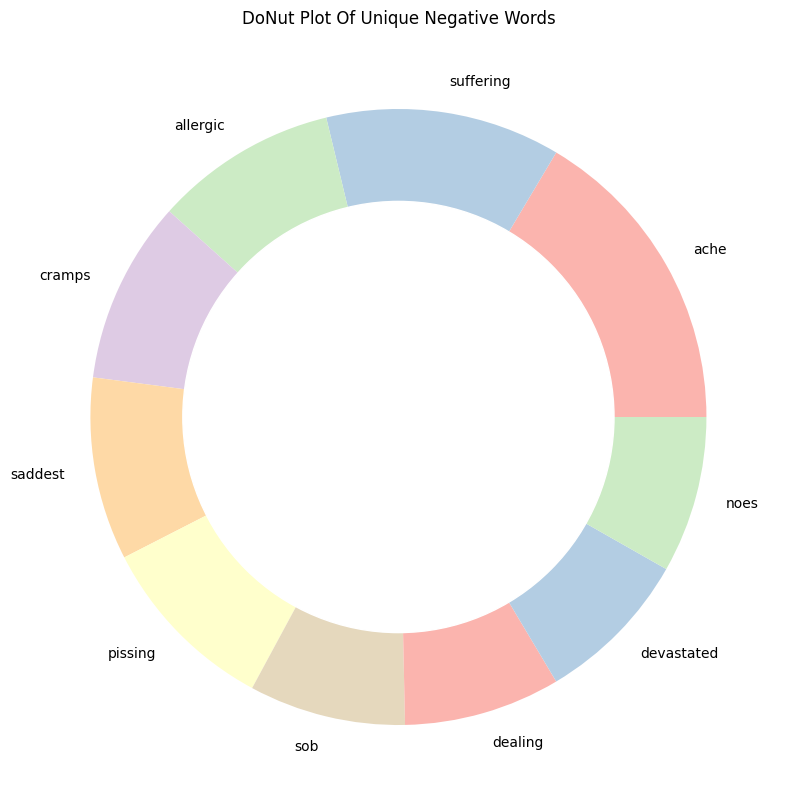

In [79]:
!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7

from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [80]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


In [81]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
d = '/kaggle/input/masks/masks-wordclouds/'

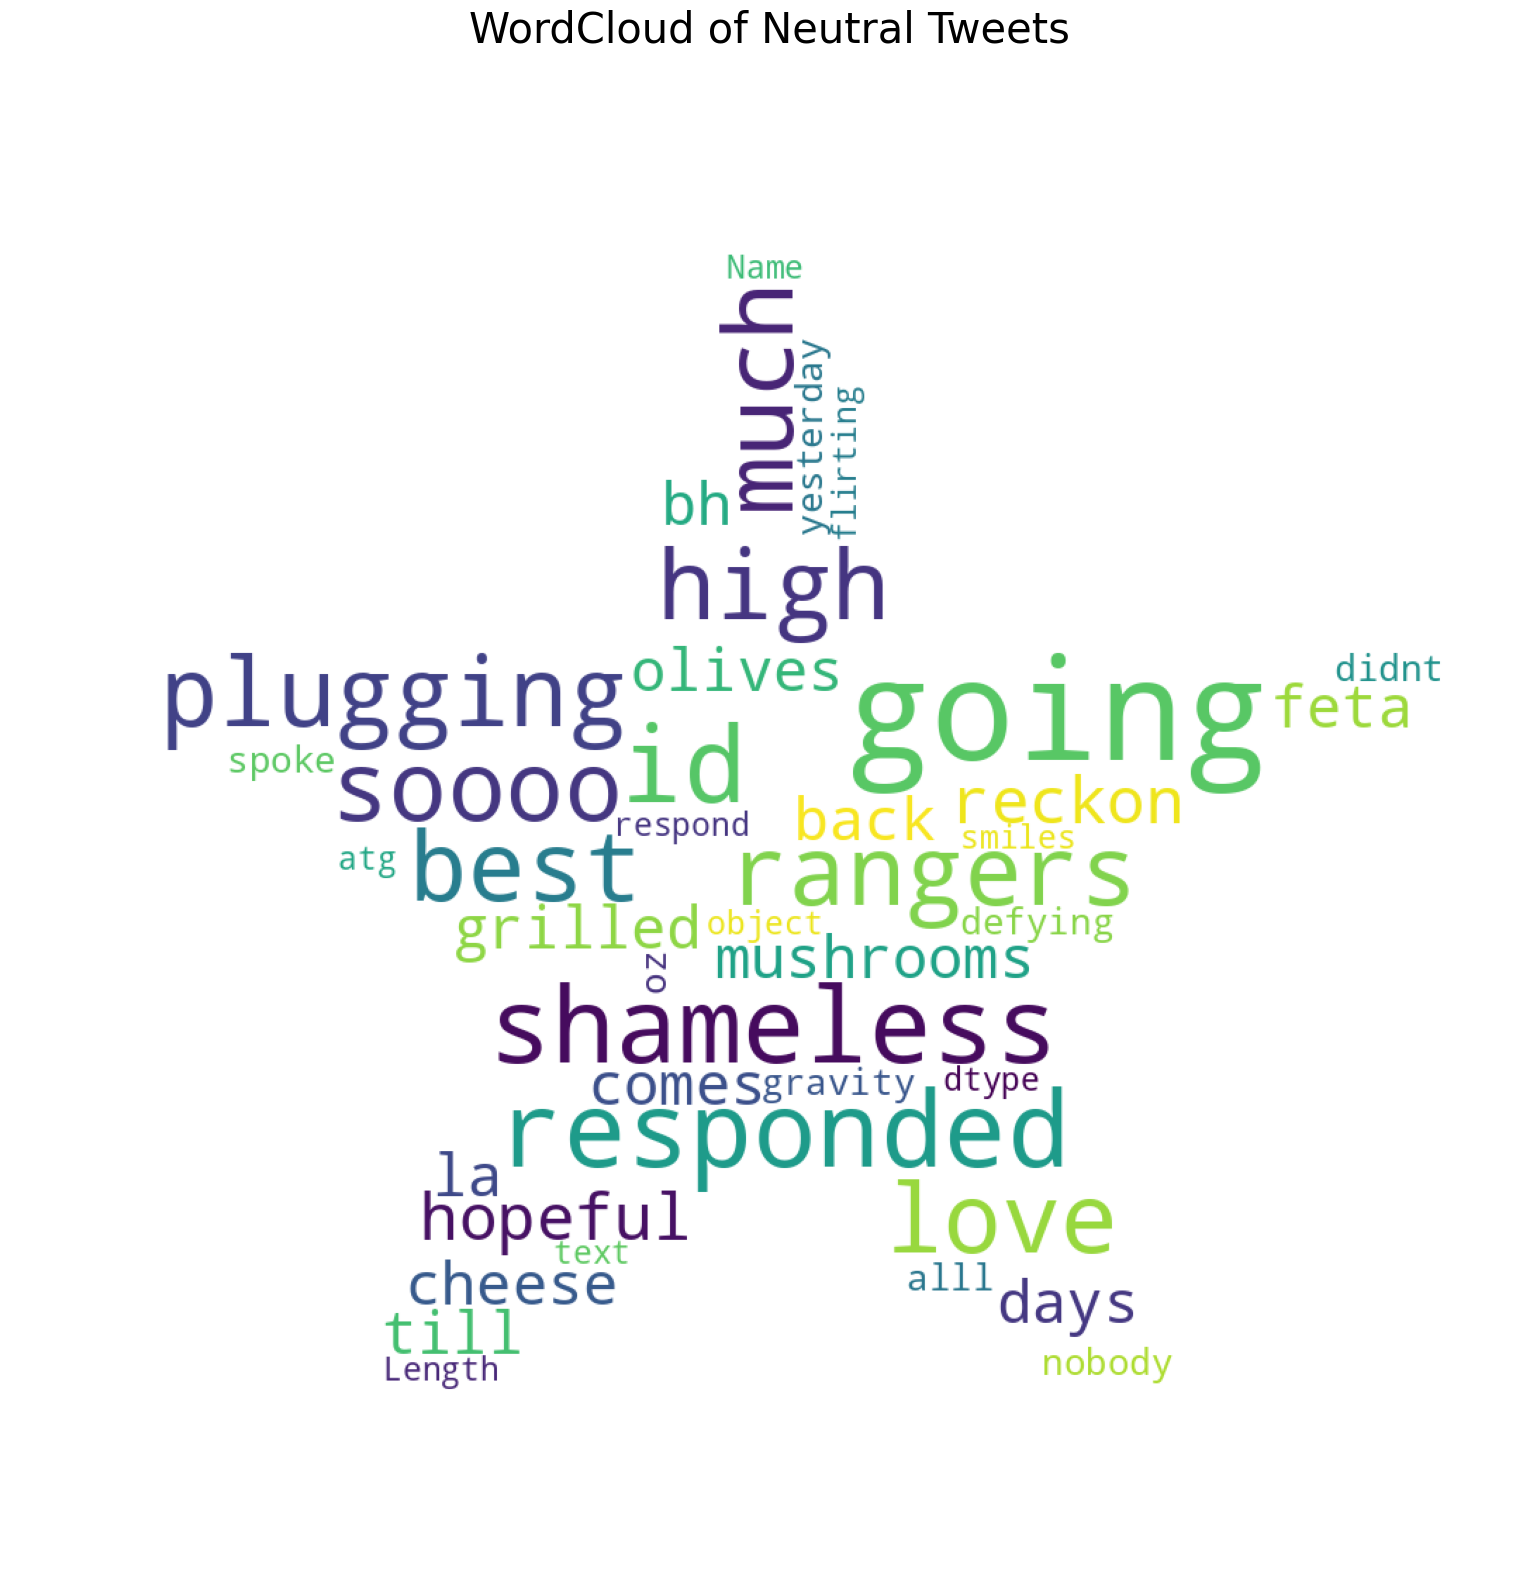

In [82]:
pos_mask = np.array(Image.open('star.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

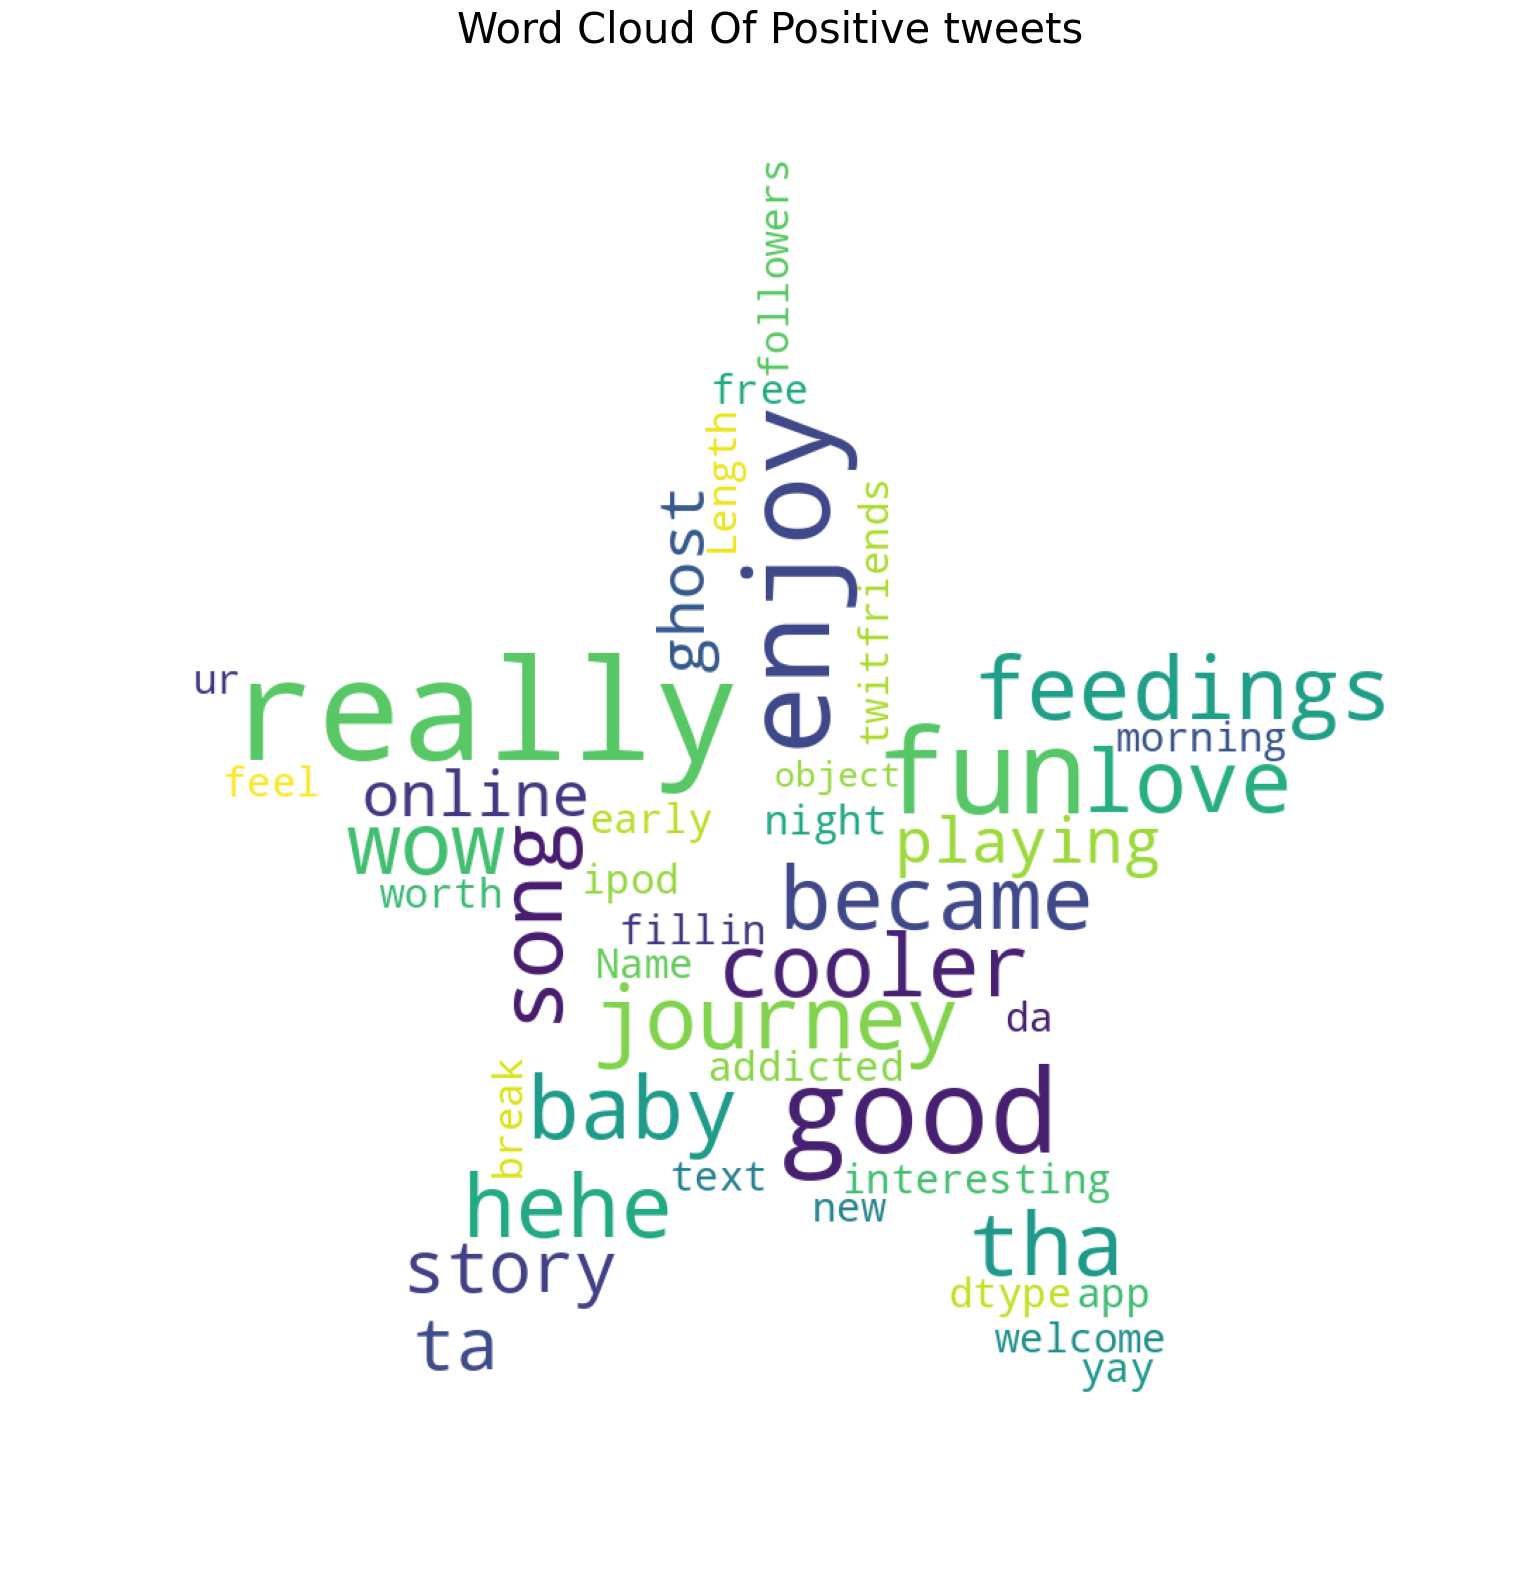

In [83]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

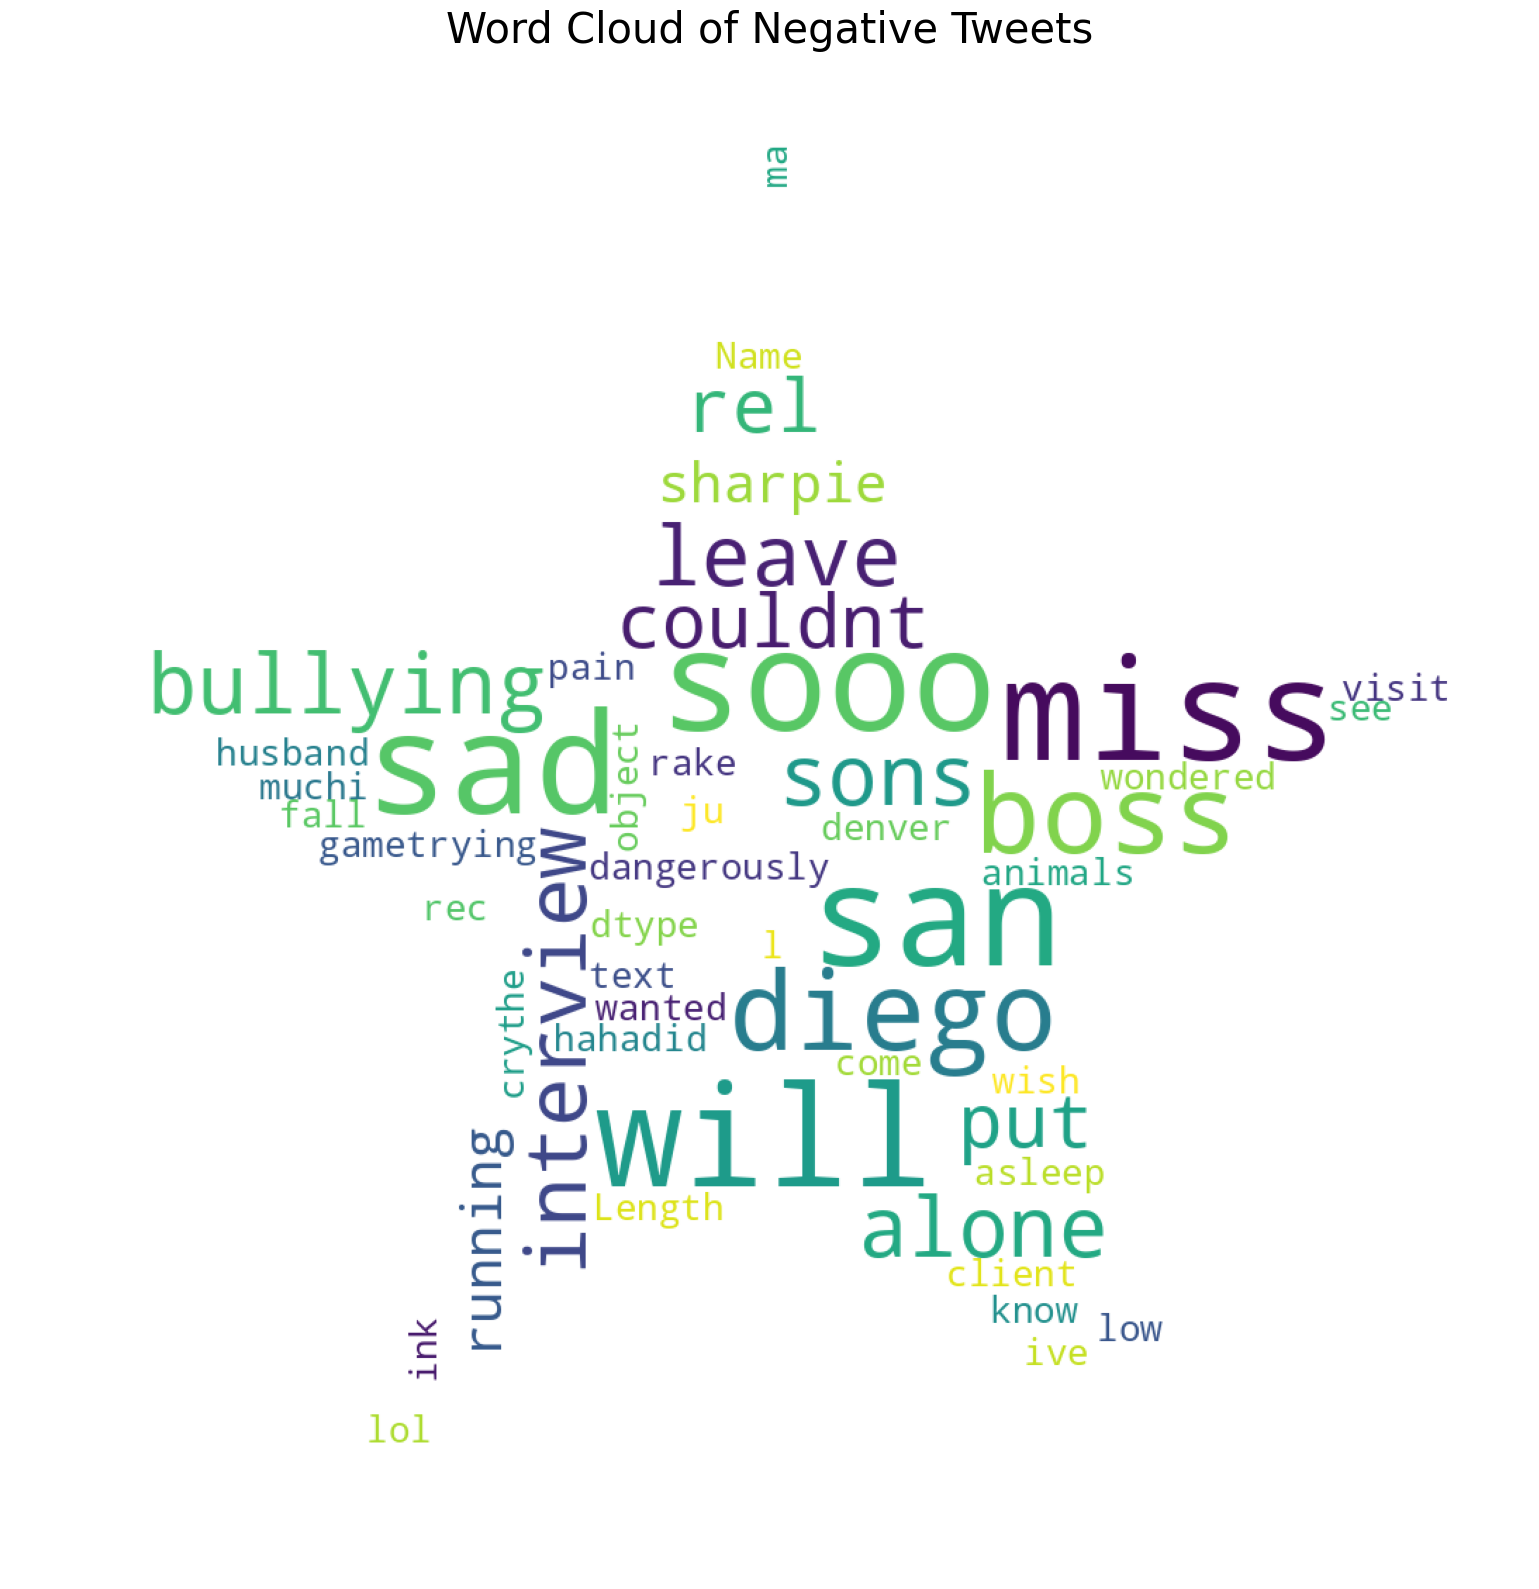

In [84]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

In [85]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_submission=pd.read_csv('sample_submission.csv')

In [86]:
#Number Of words in main Text in train set
df_train['Num_words_text']=df_train['text'].apply(lambda x:len(str(x).split()))

In [87]:
df_train=df_train[df_train['Num_words_text']>=3]

In [88]:
def save_model(output_dir, nlp, new_model_name):


  ''' This Function Saves model to
    given output directory'''

  output_dir=f'./'
  if output_dir is not None:
    if not os.path.exists(output_dir):
      os.makedirs(output_dir)
    nlp.meta["name"]=new_model_name
    nlp.to_disk(output_dir)
    print("Saved model to",output_dir)

In [89]:
# pass model = nlp if you want to train on top of existing model
!pip install spacy-lookups-data
!python -m spacy download en_core_web_md


import spacy
from spacy.pipeline import EntityRecognizer
#!python -m spacy download spacy-lookups-data
from spacy.lookups import Lookups
from spacy.lang.en import English

# Load the spaCy model


# Load lookups data
lookups = Lookups()
lookups.add_table("lexeme_norm", {})

# Add the lookups to the nlp pipeline
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")



  # Load the spaCy model
    nlp = spacy.load('en_core_web_md')

  # Create the NER pipeline component
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')  # This might not be necessary in newer versions
        nlp.add_pipe('ner', last=True)
    else:
        ner = nlp.get_pipe('ner')

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
   # if "ner" not in nlp.pipe_names:
    #    ner = nlp.create_pipe("ner")
    #    nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    #else:
     #   ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses,
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 8.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [90]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = './'
    elif sentiment == 'negative':
        model_out_path = './'
    return model_out_path

In [91]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [92]:
#sentiment='positive'
#from spacy.training import Example
#start = text.find('selected_text')
#end = start + len('selected_text')
#train_data = [Example.from_dict(row.to_dict(), {"entities": [[start, end, 'selected_text']]}) for index, row in df_train.iterrows() if row.sentiment == sentiment]
#train_data=get_training_data(sentiment)
#model_path=get_model_out_path(sentiment)
#train(train_data, model_path, n_iter=3, model=None)

In [93]:
import os
import random
from tqdm import tqdm
import pandas as pd
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
from spacy.lookups import Lookups
from spacy.lang.en import English

def save_model(output_dir, nlp, new_model_name):
    ''' This function saves the spaCy model to the given output directory '''
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""

    # Load the spaCy model
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # Create the NER pipeline component
    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe('ner', last=True)
    else:
        ner = nlp.get_pipe('ner')

    # Add labels to the NER
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # Get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        if model is None:
            optimizer = nlp.begin_training()
        else:
            optimizer = nlp.resume_training()

        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            losses = {}
            for batch in batches:
                examples = [Example.from_dict(nlp.make_doc(text), annotation) for text, annotation in batch]
                nlp.update(examples, drop=0.5, losses=losses)
            print("Losses", losses)

    save_model(output_dir, nlp, 'st_ner')

def get_model_out_path(sentiment):
    '''
    Returns Model output path based on sentiment.
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = './positive_model'
    elif sentiment == 'negative':
        model_out_path = './negative_model'
    return model_out_path

def get_training_data(sentiment):
    '''
    Returns training data in the format needed to train spaCy NER.
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row['sentiment'] == sentiment:
            selected_text = row['selected_text']
            text = row['text']
            start = text.find(selected_text)
            if start != -1:  # Ensure the selected text is found in the text
                end = start + len(selected_text)
                train_data.append((text, {"entities": [(start, end, 'selected_text')]}))
            else:
                print(f"Selected text '{selected_text}' not found in text for row {index}.")
    return train_data

# Load the training data
df_train = pd.read_csv('train.csv')

# Set sentiment for training
sentiment = 'positive'

# Get the training data for the specified sentiment
train_data = get_training_data(sentiment)

# Get the model output path
model_path = get_model_out_path(sentiment)

# Train the model
train(train_data, model_path, n_iter=3, model=None)


Created blank 'en' model


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text " http://bit.ly/Msize  There you go dear  I love he..." with entities "[(41, 46, 'selected_text')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text " It will be an Adventure!  Have FUN with your 5 yr..." with entities "[(83, 112, 'selected_text')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text " Haha I know, I cant h

Losses {'ner': 13298.687739315372}


 67%|██████▋   | 2/3 [02:28<01:12, 72.14s/it]

Losses {'ner': 12005.879302680425}


100%|██████████| 3/3 [03:30<00:00, 70.21s/it]

Losses {'ner': 11734.041745619903}
Saved model to ./positive_model


In [96]:
sentiment='negative'
train_data=get_training_data(sentiment)
model_path=get_model_out_path(sentiment)
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text " im home alone in the house and imma scared  x" with entities "[(35, 43, 'selected_text')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "is sad that she is not seeing Basshunter at Metrop..." with entities "[(0, 9, 'selected_text')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning:

[W030] Some entities could not be aligned in the text "My flip flop just broke...walkin

Losses {'ner': 12836.018743030309}


 67%|██████▋   | 2/3 [02:17<01:07, 67.30s/it]

Losses {'ner': 11424.010640136265}


100%|██████████| 3/3 [03:24<00:00, 68.12s/it]

Losses {'ner': 11185.353610144855}
Saved model to ./negative_model


In [97]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [98]:
selected_texts = []
#MODELS_BASE_PATH = '../input/tse-spacy-model/models/'
MODELS_BASE_PATH = './'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'positive_model')
    model_neg = spacy.load(MODELS_BASE_PATH + 'negative_model')

    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))

df_test['selected_text'] = selected_texts

Loading Models  from  ./


In [99]:
df_submission['selected_text']=df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Good
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
...,...,...
3529,e5f0e6ef4b,tired
3530,416863ce47,Thanks
3531,6332da480c,I know what you mean. My little dog is sinkin...
3532,df1baec676,_sutra what is your next youtube video gonna b...
